In [1]:
import os
import os.path as op

import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error
import joblib

C:\MinGW\ipykernel_38800\2136253286.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Clean and Split data


In [2]:
df = pd.read_csv("data/rodkaidee.csv")
df.head(5)

,Brand,Model,Engine,Segment,Year,Mileage,Province,Price,Color
0,Mazda,Mazda2,1.3,B-Segment,2022,"15,640",กรุงเทพมหานคร,"499,000",Gray
1,Suzuki,Celerio,1.0,Eco Car,2021,"9,545",กรุงเทพมหานคร,"315,000",White
2,Mitsubishi,Mirage,1.2,Eco Car,2021,"10,900",นนทบุรี,"335,000",Gray
3,Nissan,March,1.2,Eco Car,2021,"12,000",กรุงเทพมหานคร,"339,000",Silver
4,Mitsubishi,Attrage,1.2,Eco Car,2021,"25,706",กาญจนบุรี,"350,000",Gray


In [3]:
df['Mileage'] = df['Mileage'].apply(lambda x: float(x.replace(",", "")))
df['Price'] = df['Price'].apply(lambda x: float(x.replace(",", "")))

df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)

In [4]:
len(df_train), len(df_val)

(5916, 1480)

### One hot encoding


In [12]:
CAT_CoLUMN = ["Brand", "Model", "Engine", "Segment", "Province", "Color"]

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
cat_train_array = ohe.fit_transform(df_train[CAT_CoLUMN])
cat_val_array = ohe.fit_transform(df_val[CAT_CoLUMN])

In [13]:
cat_train_array.shape, cat_val_array.shape

((5916, 136), (1480, 115))

### Normalize continuous columns


In [14]:
year_scaler = MinMaxScaler()
mileage_scaler = MinMaxScaler()
price_scaler = MinMaxScaler()

In [17]:
scaled_year = year_scaler.fit_transform(df_train[["Year"]])
scaled_mileage = mileage_scaler.fit_transform(df_train[["Mileage"]])
scaled_price = price_scaler.fit_transform(df_train[["Price"]])

In [19]:
X_train = np.hstack([
    ohe.transform(df_train[CAT_CoLUMN]),
    year_scaler.transform(df_train[["Year"]]),
    mileage_scaler.transform(df_train[["Mileage"]]),
    price_scaler.transform(df_train[["Price"]])
])
y_train = price_scaler.transform(df_train[["Price"]])

X_val = np.hstack([
    ohe.transform(df_val[CAT_CoLUMN]),
    year_scaler.transform(df_val[["Year"]]),
    mileage_scaler.transform(df_val[["Mileage"]]),
    price_scaler.transform(df_val[["Price"]])
])

y_val = price_scaler.transform(df_val[["Price"]])

In [20]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((5916, 118), (5916, 1), (1480, 118), (1480, 1))

In [22]:
save_dir = "trained_models"
os.makedirs(save_dir, exist_ok=True)
joblib.dump(ohe, op.join(save_dir, "one_hot_encoder.joblib"))
joblib.dump(year_scaler, op.join(save_dir, "year_scaler.joblib"))
joblib.dump(mileage_scaler, op.join(save_dir, "mileage_scaler.joblib"))
joblib.dump(price_scaler, op.join(save_dir, "price_scaler.joblib"))

['trained_models\\price_scaler.joblib']

## Train Linear Regression Model


In [23]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [24]:
y_pred = lr_model.predict(X_val)

In [27]:
df_val["Predicted_Price_LR"]= price_scaler.inverse_transform(y_pred).ravel()
df_val

,Brand,Model,Engine,Segment,Year,Mileage,Province,Price,Color,Predicted_Price_LR
2759,Toyota,Vios,1.5,B-Segment,2015,62639.0,กรุงเทพมหานคร,338000.0,Gray,338000.0
2846,Toyota,Altis,1.6,C-Segment,2015,65615.0,สงขลา,385000.0,Silver,385000.0
6682,Honda,Civic,2.0,C-Segment,2007,203000.0,สิงห์บุรี,295000.0,Gray,295000.0
3262,Toyota,Yaris,1.2,Eco Car,2014,124007.0,ราชบุรี,339000.0,White,339000.0
486,Mazda,Mazda2,1.3,B-Segment,2019,51957.0,กรุงเทพมหานคร,439000.0,Blue,439000.0
...,...,...,...,...,...,...,...,...,...,...
6782,Toyota,Yaris,1.5,Eco Car,2006,156479.0,กรุงเทพมหานคร,185000.0,Gray,185000.0
110,Mitsubishi,Attrage,1.2,Eco Car,2020,13000.0,สระบุรี,385000.0,White,385000.0
51,Toyota,Yaris,1.2,Eco Car,2021,2000.0,นนทบุรี,519000.0,White,519000.0
1109,Toyota,Altis,1.6,C-Segment,2018,94970.0,นนทบุรี,477000.0,Gray,477000.0


### Evaluate and Plot relationship between actual and predicted value


In [28]:
print("MSE = ", ((y_val - y_pred)**2).sum() / len(y_val))
print("MSE (scikit learn) = ", mean_squared_error(y_val, y_pred))

MSE =  2.072182038832164e-30
MSE (scikit learn) =  2.072182038832164e-30


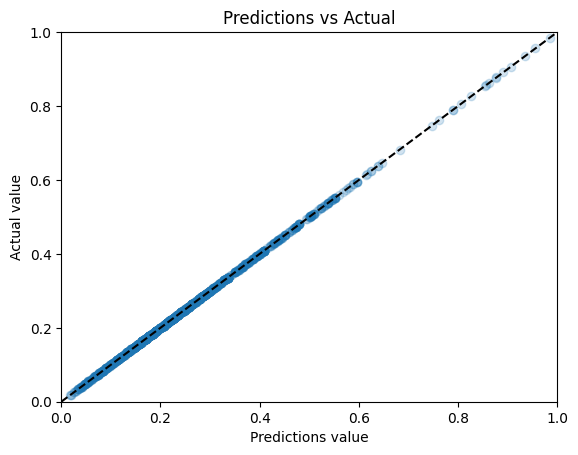

In [29]:
# Plot a perfect prediction line.
plt.plot([0, 1], [0, 1],  "--", color="black",)
# Plot the predictions vs the actual values.
plt.Figure(figsize=(10, 10))
plt.scatter(y_pred, y_val, alpha=0.2)

plt.xlabel("Predictions value")
plt.ylabel("Actual value")
plt.title("Predictions vs Actual")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

### save model


In [30]:
joblib.dump(lr_model, "trained_models/carprice_model_linear_regression.joblib")

['trained_models/carprice_model_linear_regression.joblib']

## Train Neural Network Model


In [31]:
from torch.utils.data import Dataset, DataLoader

# TODO: Create dataset from numpy array X, y
class CarPriceDataset(Dataset):
    def __init__(self, X, y = None):
        self.X = X
        if y is not None:
            self.y = y
        else:
            self.y = None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        else:
            return self.X[idx]

In [32]:
train_dataset = CarPriceDataset(X_train, y_train)
val_dataset = CarPriceDataset(X_val, y_val)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

x_sample, y_sample = next(iter(train_dataloader))
x_sample.shape, y_sample.shape

(torch.Size([32, 118]), torch.Size([32, 1]))

In [47]:
class CarPriceModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.linear(x)
        return x

In [34]:
n_features, n_output = X_train.shape[1], y_train.shape[1]
print(n_features)

118


In [48]:
model = CarPriceModel(input_size=n_features, output_size=n_output)
model

CarPriceModel(
  (linear): Linear(in_features=118, out_features=1, bias=True)
)

In [49]:
def train(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    loss_fn = nn.MSELoss(reduction='mean'),
    num_epochs = 100,
    update_frequency = 10,
):
    for epoch in tqdm(range(num_epochs)):
        model.train() # model in train mode
        for x,y in train_dataloader:
            y_pred = model(x.float()) # forward pass
            loss = loss_fn(y_pred, y.float()) # calculate the loss
            loss.backward() # backward pass
            optimizer.step() # update the model parameters
            optimizer.zero_grad() # reset the gradient

        model.eval() # model in eval mode
        with torch.no_grad():
            for x, y in test_dataloader:
                y_pred = model(x.float()) # forward pass
                loss = loss_fn(y_pred, y.float()) # calculate the loss
            
            if epoch % update_frequency == 0:
                print(f"Epoch {epoch}: {loss.item()}")


In [50]:
# Define the loss function and the optimizer.
learning_rate = 1e-3
loss_fn = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model.
num_epochs = 120
update_frequency = 10

train(
    model = model,
    train_dataloader = train_dataloader,
    test_dataloader = val_dataloader,
    optimizer = optimizer,
    loss_fn = loss_fn,
    num_epochs = num_epochs,
    update_frequency = update_frequency,
)

  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0: 0.0046212514862418175
Epoch 10: 0.00019837073341477662
Epoch 20: 3.1630210287403315e-05
Epoch 30: 1.5596157254549325e-07
Epoch 40: 9.699972736143536e-08
Epoch 50: 3.8333763541231747e-07
Epoch 60: 2.90479897557816e-06
Epoch 70: 6.728750463480537e-07
Epoch 80: 6.0250945352890994e-06
Epoch 90: 9.844712849371717e-07
Epoch 100: 1.7758768535713898e-06
Epoch 110: 1.4042338989384007e-06


### Evaluate the model on test set with MSE


In [51]:
def predict(model, test_dataloader):
    model.eval()
    y_pred_list = []
    y_true_list = []
    for x, y in test_dataloader:
        y_pred = model(x.float())
        prediction = y_pred.detach().numpy()
        y = y.numpy()
        y_pred_list.extend(prediction)
        y_true_list.extend(y)
    y_pred_list = np.concatenate(y_pred_list)
    y_true_list = np.concatenate(y_true_list)
    return y_pred_list, y_true_list

In [52]:
y_pred, y_true = predict(model, val_dataloader)

In [53]:
mean_squared_error(y_true, y_pred)

2.1494609472983346e-06

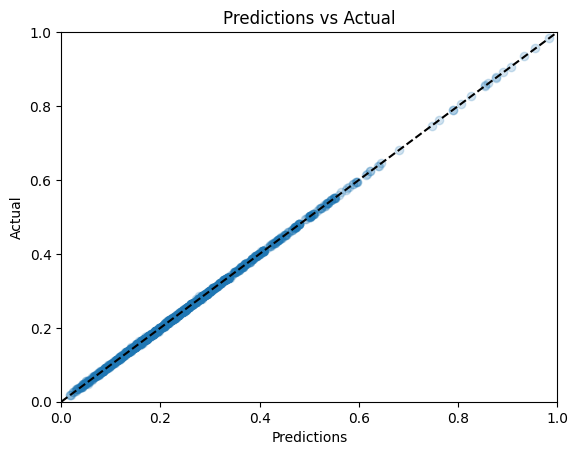

In [54]:
# Plot a perfect prediction line.
plt.plot([0, 1], [0, 1],  "--", color="black",)
# Plot the predictions vs the actual values.
plt.scatter(y_pred, y_true, alpha=0.2)

plt.xlabel("Predictions")
plt.ylabel("Actual")
plt.title("Predictions vs Actual")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

### save the model


In [55]:
torch.save(model.state_dict(), "trained_models/carprice_model_mse_0003.pth")

## Train a Neural Network with multiple layers (MLP)


In [56]:
class CarPriceTwoLayerModel(nn.Module):
    def __init__(self, input_size, output_size, intermediate_dim = 10):
        super().__init__()
        self.linear1 = nn.Linear(input_size, intermediate_dim)
        self.linear2 = nn.Linear(intermediate_dim, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

model_two_layers = CarPriceTwoLayerModel(input_size=n_features, output_size=n_output)
model_two_layers

CarPriceTwoLayerModel(
  (linear1): Linear(in_features=118, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [57]:
# Define the loss function and the optimizer.
learning_rate = 1e-3 # = 0.001
loss_fn = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model_two_layers.parameters(), lr=learning_rate)

# Train the model.
num_epochs = 120
update_frequency = 10

train(
    model=model_two_layers,
    train_dataloader=train_dataloader,
    test_dataloader=val_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    num_epochs=num_epochs,
    update_frequency=update_frequency,
)

  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0: 0.0023392816074192524
Epoch 10: 3.589734114939347e-05
Epoch 20: 1.8136873904950335e-06
Epoch 30: 1.1750828434742289e-06
Epoch 40: 3.766687086681486e-06
Epoch 50: 1.65482924785465e-06
Epoch 60: 5.365675406210357e-07
Epoch 70: 2.5842650757113006e-06
Epoch 80: 6.1440605350071564e-06
Epoch 90: 2.2638432710664347e-06
Epoch 100: 5.37442838322022e-06
Epoch 110: 4.908342361886753e-06


In [58]:
y_test, y_true_dl = predict(model_two_layers, val_dataloader)
mse_score = mean_squared_error(y_test, y_true_dl)
mse_score

1.7390112783306465e-05

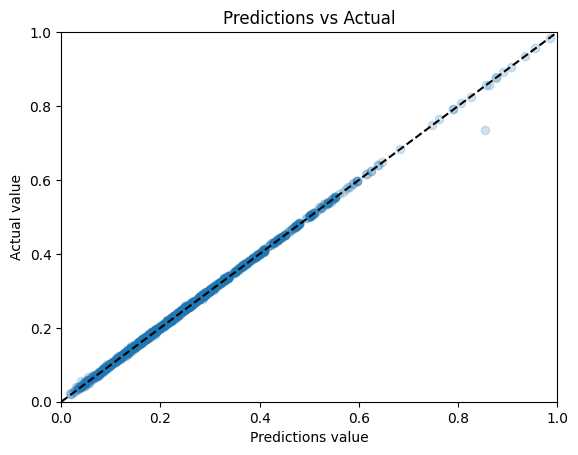

In [59]:
# Plot a perfect prediction line.
plt.plot([0, 1], [0, 1],  "--", color="black",)
# Plot the predictions vs the actual values.
plt.scatter(y_true_dl, y_test, alpha=0.2)

plt.xlabel("Predictions value")
plt.ylabel("Actual value")
plt.title("Predictions vs Actual")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [60]:
torch.save(model_two_layers.state_dict(), f"trained_models/carprice_two_layer_model_mse_00015.pth")